# A Breef Data Science Pipeline - Part 3

#### [Institute of Data Science at Maastricht University](https://www.maastrichtuniversity.nl/research/institute-data-science)
---

## Data Analysis
---

 Data Dimension Milestones
 
 - Define a Method
 - Features to train and test
 - Predictive Model
 - Evaluation Metrics


In any case is easy to identify how to tackle a predictive probles, since is important to identify the method to respond the target variables.
    - Pattern: Anomaly Detection
    - Cicles, time: Time Series
    - Category: Classification
    - Quantity: Regression
    - Design a concept to visualize the outcome
- Choose and develop the algorithm (e.g. if Classification, SVM or Bayes?)

![](../img/machinelearning.png)  
*This image is an extract from [SAP](https://blogs.sap.com/2016/05/11/go-for-the-intelligent-enterprise/) via [@JM_SAP](https://twitter.com/JM_SAP)*

---
- ### Define a Method

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In this case, we are treating with continues variables, the number of crimes, currently we have different dimesions to describe those crimes, also some other numerical variables thought.

We assume is important to take into account the number of Violent Crimes since is going to be developed new public policies, so we want to predict in a certain year on a certain municipality the number of violent crimes.

Let's see if is possible.

- Dataset name: Crime, type of crime, municipality  
- Additional Information: [Source](https://data.overheid.nl/data/dataset/misdrijven-soort-misdrijf-gemeente), 
[Metadata](https://politieopendata.cbs.nl/portal.html?_la=nl&_catalog=Politie&graphtype=Table&tableId=47004NED&_theme=66), 
[License](https://data.overheid.nl/licenties-voor-hergebruik) CC-BY 4.0  

In [2]:
df_crime = pd.read_csv('../data/crime/crimes_municipality_ingest.tsv', sep='\t', index_col=0)

In [3]:
df_population = pd.read_csv('../data/crime/population_netherlands.tsv', sep='\t')

In [4]:
df_population.set_index('CBScode', inplace=True)

In [5]:
df_crime.columns

Index(['CBScode', 'Perioden', '  HIC: Theft / burglary dwelling, complete',
       '  HIC: Theft / burglary dwelling, attempts', 'HIC: Violent Crime',
       'HIC: Street Roof', 'HIC: Robberies', 'Undermining public order',
       'Threat', 'Fire / Explosion', 'Theft of moped, moped, bike',
       'Theft of / from vehicles', 'Theft of motor vehicles',
       'Theft / burglary companies / institutions',
       'Theft / burglary garage / barn / shed', 'Drug trafficking',
       'Trespassing', 'mistreatment', 'Overt violence (person)',
       'Or destruction. cause damage', 'Arms Trade', 'pickpocketing',
       'morals Felony', 'Municipality', 'Province', 'Population',
       'Population_density(p/km)', 'Municipality Size'],
      dtype='object')

---
- ### Features to Train and Test

Choose the crime you want to predict

In [6]:
crimeType='HIC: Violent Crime'

In [7]:
# create a table to train a crime over certain period
def get_crime_table(crimeType):    
    df = pd.DataFrame()
    for column in df_crime['Perioden'].unique():
        period = df_crime[df_crime['Perioden'] ==str(column)].groupby(['CBScode']).sum()[crimeType]
        df[str(column)] = period
    return df

In [8]:
df_features = pd.merge(get_crime_table(crimeType), df_population, how='left', left_index=True, right_index=True)

In [9]:
df_features.fillna(0, inplace=True)

In [10]:
df_features.sort_values('Population_density(p/km)', ascending=False).head(10)

,2014JJ00,2015JJ00,2016JJ00,2017JJ00,Municipality,Province,Population,Population_density(p/km)
CBScode,,,,,,,,
GM0518,4738.0,4279.0,3996.0,4066.0,"Hague, TheThe Hague",South Holland,508592.0,6131.0
GM0546,800.0,620.0,639.0,640.0,Leiden,South Holland,121199.0,5409.0
GM0392,840.0,760.0,730.0,698.0,Haarlem,North Holland,155205.0,5195.0
GM0363,7929.0,7692.0,7645.0,7228.0,Amsterdam,North Holland,853312.0,4767.0
GM0502,351.0,397.0,366.0,306.0,Capelle aan den IJssel,South Holland,66177.0,4640.0
GM0606,511.0,516.0,557.0,510.0,Schiedam,South Holland,76487.0,4230.0
GM0513,558.0,471.0,437.0,436.0,Gouda,South Holland,70923.0,4225.0
GM0503,578.0,550.0,441.0,398.0,Delft,South Holland,101493.0,4218.0
GM0556,139.0,116.0,110.0,136.0,Maassluis,South Holland,32097.0,3751.0


Remember: Bad data leads to bad models. Always check your data first.

Assured that our data is now as clean as we can make it — and armed with some cursory knowledge of the distributions and relationships in our data set — it's time to make the next big step in our analysis: Splitting the data into training and testing sets.

A training set is a random subset of the data that we use to train our models.

A testing set is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforseen data.

Especially in sparse data sets like ours, it's easy for models to overfit the data: The model will learn the training set so well that it won't be able to handle most of the cases it's never seen before. This is why it's important for us to build the model with the training set, but score it with the testing set.

Note that once we split the data into a training and testing set, we should treat the testing set like it no longer exists: We cannot use any information from the testing set to build our model or else we're cheating.

In [11]:
X = df_features.select_dtypes(exclude='object')
X = X.loc[:, X.columns != '2017JJ00'].values
y = df_features['2017JJ00'].values

In [13]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

With our data split, we can start fitting models to our data

---
- ### Predictive Model

#### Linear Regression

In [14]:
from sklearn import linear_model

In [15]:
# Model fit
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
# Model Predict
y_predict = lr_model.predict(X_test)

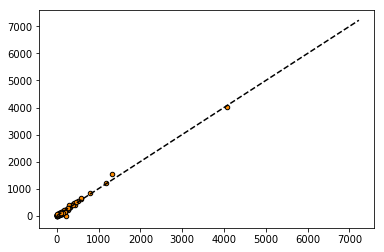

In [16]:
# Plot the results
plt.figure()
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.scatter(y_test, y_predict, s=20, edgecolor="black", c="darkorange", label="Test vs Real")

In [18]:
lr_model.score(X_test, y_test)

0.9910780084174352

In [21]:
year1 = 50.
year2 = 60.
year3 = 70.
population = 60000.
pop_density = 200.

In [22]:
new_data = np.array([[year1, year2, year3, population, pop_density]])

In [24]:
print('Having {} for the last 3 years {},{},{}\nand a population of {} with a density of {}\nPrediction of next year {}'.format(
    crimeType, year1, year2, year3, population, pop_density, lr_model.predict(new_data)[0]))

Having HIC: Violent Crime for the last 3 years 50.0,60.0,70.0
and a population of 60000.0 with a density of 200.0
Prediction of next year 53.35003347495084


#### Decision Tree Regression

The `decision trees` is used to fit a sine curve with addition noisy observation. As a result, it learns local linear regressions approximating the sine curve.

We can see that if the maximum depth of the tree (controlled by the `max_depth` parameter) is set too high, the decision trees learn too fine
details of the training data and learn from the noise, i.e. they overfit.

The nice part about decision tree is that they are scale-invariant, i.e., the scale of the features does not affect their performance, unlike many Machine Learning models. In other words, it doesn't matter if our features range from 0 to 1 or 0 to 1,000; decision tree classifiers will work with them just the same.

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
# Model fit
dt_model = DecisionTreeRegressor(max_depth=2)
dt_model.fit(X_train, y_train)
# Model Predict
y_predict = dt_model.predict(X_test)

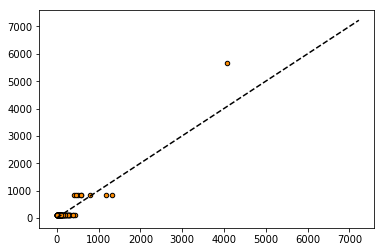

In [27]:
# Plot the results
plt.figure()
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.scatter(y_test, y_predict, s=20, edgecolor="black", c="darkorange", label="Test vs Real")

#### Neural Networks - Multilayer Perceptorns Regressor

In [34]:
from sklearn.neural_network import MLPRegressor

In [35]:
# Model fit
nn_model = MLPRegressor()
nn_model.fit(X_train, y_train)
# Model Predict
y_predict = nn_model.predict(X_test)

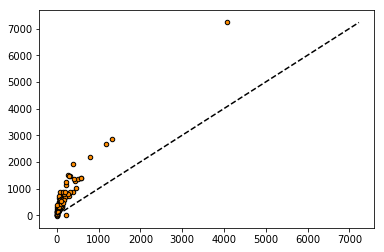

In [36]:
# Plot the results
plt.figure()
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.scatter(y_test, y_predict, s=20, edgecolor="black", c="darkorange", label="Test vs Real")

---
- ### Evaluation Metrics

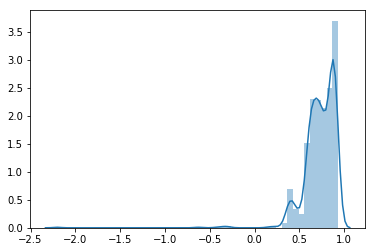

In [37]:
model_scores = []

for repetition in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    model = DecisionTreeRegressor(max_depth=2)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_scores.append(score)
    
sb.distplot(model_scores)

With the summary on hand, ask…
- Does the outcome makes sense?
- What does the important variables mean? (on “human” language)
- How improve the outcome? (add more target variables? Change it? Change the parameters? Change the method?)

---
## Data Communication

 Data Dimension Milestones
 
- Documentation
- Results
- Visualization
- Data Product

---
- ### Documentation

- Document the procedures
- Versioning control of script for replicable science
- Develop a Data Storytelling

Ensuring that our work is reproducible is the last and — arguably — most important step in any analysis. As a rule, we shouldn't place much weight on a discovery that can't be reproduced. As such, if our analysis isn't reproducible, we might as well not have done it.

Notebooks like this one go a long way toward making our work reproducible. Since we documented every step as we moved along, we have a written record of what we did and why we did it — both in text and code.

Beyond recording what we did, we should also document what software and hardware we used to perform our analysis. This typically goes at the top of our notebooks so our readers know what tools to use.

[Sebastian Raschka](https://sebastianraschka.com/) created a handy notebook tool for this:

In [38]:
#!pip install watermark
#only install once

In [102]:
%load_ext watermark

In [105]:
%watermark -a 'Maastricht University' -nmv --packages numpy,pandas,sklearn,matplotlib

Maastricht University Mon Feb 26 2018 

CPython 3.5.4
IPython 6.2.1

numpy 1.14.1
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.1.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


---
- ### Results

There we have it: We have a complete and reproducible Machine Learning pipeline to demo to our company's Head of Data. We've met the success criteria that we set from the beginning (>90% accuracy), and our pipeline is flexible enough to handle new inputs or flowers when that data set is ready

- With the Data-story (Notebook, Tableau story, R-Markdown, Slides, etc) on hand, ask… What’s next? 
- Improve the model?
- Improve the data?
- Join more researchers to the problem?
